In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


https://www.kaggle.com/udbhavpangotra/tps-apr21-eda-model


https://www.kaggle.com/hiro5299834/tps-apr-2021-voting-pseudo-labeling

# KAGGLE 스터디 

In [2]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [3]:
TARGET = 'Survived'

N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

In [4]:
#랜덤 시드 생성
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

## 데이터 전처리

### lode data

In [5]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')
#test_df[TARGET] = pd.read_csv("../input/tps-apr-2021-label/voting_submission_from_5_best.csv")[TARGET]

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
#reset_index : 인덱스를 세팅한다. drop=True를 하면 인덱스를 세팅한걸 삭제함. 


In [6]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (100000, 12)
Rows and Columns in test dataset: (100000, 11)


### 결측치 갯수 출력

In [7]:
print('Missing values per columns in train dataset')
for col in train_df.columns:
    temp_col = train_df[col].isnull().sum()
    print(f'{col}: {temp_col}')
print()
print('Missing values per columns in test dataset')
for col in test_df.columns:
    temp_col = test_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in train dataset
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3292
SibSp: 0
Parch: 0
Ticket: 4623
Fare: 134
Cabin: 67866
Embarked: 250

Missing values per columns in test dataset
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3487
SibSp: 0
Parch: 0
Ticket: 5181
Fare: 133
Cabin: 70831
Embarked: 277


### Filling missing values

In [8]:
#나이는 나이의 평균치로 채운다.
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())

#cabin은 문자열을 분할하고, 제일 첫번째 글자를 따와서 넣는다. 결측치엔 X를 넣는다.
#strip() : 양쪽 공백을 지운다. 여기서느 x[0]외엔 다 지우는듯. 
all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())


#print(all_df['Ticket'].head(10))
# Ticket, fillna with 'X', split string and take first split 
#split() : 문자열 나누기. 디폴트는 ' '이고, 문자를 가진 데이터들이 전부 띄워쓰기로 구분되어있기때문에 가능. 
all_df['Ticket'] = all_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

#pclass에 따른 Fare의 평균을 구해서 dictionary형태로 만든다. 
fare_map = all_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
#fare의 결측치에 본인 행의 pclass 값을 넣고, 그 값을 fare 평균에 맵핑시킨다.  
all_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
#유독 높은 가격이나 낮은 가격이 있기때문에, 이상치의 영향을 줄이기 위해서 Fare에 log를 취해준다.
all_df['Fare'] = np.log1p(all_df['Fare'])


#항구의 결측치를 X로 채운다. 
all_df['Embarked'] = all_df['Embarked'].fillna('X')

#이름은 성만 사용한다.
all_df['Name'] = all_df['Name'].map(lambda x: x.split(',')[0])


In [9]:
# import copy
# imsi_df= copy.deepcopy(all_df)

# imsi_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
# imsi_df['Fare'] = np.log1p(all_df['Fare'])
# print(imsi_df['Fare'].head())

상관 관계용으로 cabin을 라벨인코딩한 데이터프레임 cor_df
분석용으론 cabin을 원핫 인코딩한다. 

In [10]:
#라벨 인코딩 함수. c라는 매개변수를 받아서 맞게 트렌스폼 해준다. 
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

In [11]:
cor_label_cols = ['Name', 'Ticket', 'Sex','Embarked','Cabin','Pclass']
cor_numerical_cols = [ 'Age', 'SibSp', 'Parch', 'Fare']

In [12]:
scaler = StandardScaler()
cor_label_encoded_df = all_df[cor_label_cols].apply(label_encoder)
cor_numerical_df = pd.DataFrame(scaler.fit_transform(all_df[cor_numerical_cols]), columns=cor_numerical_cols)
cor_target_df = all_df[TARGET]

#all_df = pd.concat([numerical_df, label_encoded_df, target_df], axis=1)
cor_df = pd.concat([cor_numerical_df, cor_label_encoded_df, cor_target_df], axis=1)

In [13]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1.0,1,Oconnor,male,34.464565,2,0,X,3.337192,C,S
1,1,0.0,3,Bryan,male,34.464565,0,0,X,2.663750,X,S
2,2,0.0,3,Owens,male,0.330000,1,2,CA,4.280686,X,S
3,3,0.0,3,Kramer,male,19.000000,0,0,A.,2.641910,X,S
4,4,1.0,3,Bond,male,25.000000,0,0,X,2.170196,X,S


## Feature 시각화 

In [14]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

print("Done")


Done


In [15]:
color_surv= "#85c6a9"
color_nsurv="#3f3e6f"
total_num="#FAEB78"

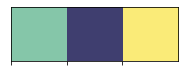

In [16]:
colors = [color_surv,color_nsurv,total_num]
sns.palplot(sns.color_palette(colors))

### 생존자 비율

In [17]:
def draw_plot(feature,num=0):
    fig, ax=plt.subplots(nrows=2,ncols=1,figsize=(8,16),)
    if(num==1):
        sns.countplot(y=all_df[feature],ax=ax[0])
    else : 
        sns.countplot(all_df[feature],ax=ax[0])
    
    surv_by_emb = all_df.groupby(feature)['Survived'].value_counts(normalize = True)
    #print(surv_by_emb)
    surv_by_emb = surv_by_emb.unstack().sort_index()
    #print(surv_by_emb)
    surv_by_emb[:15].plot(kind='bar', stacked='True', color=[color_nsurv,color_surv],ax=ax[1],alpha=0.7)
    ax[1].set_title('Proportion of survived/drowned passengers by {}'.format(feature))
    ax[1].legend(( 'Drowned', 'Survived'), loc=(1.04,0))

In [18]:
def draw_plot2(feature,ax):

    surv_by_emb = all_df.groupby(feature)['Survived'].value_counts(normalize = True)
    #print(surv_by_emb)
    surv_by_emb = surv_by_emb.unstack().sort_index()
    #print(surv_by_emb)
    surv_by_emb[:15].plot(kind='bar', stacked='True', color=[color_nsurv,color_surv],ax=ax,alpha=0.7)
    ax.set_title('Proportion of survived/drowned passengers by {}'.format(feature))
    ax.legend(( 'Drowned', 'Survived'), loc=(1.04,0))

In [19]:
#수치형 함수 그래프 

def draw_plot_num(feature,df,list_order,num=0):
    fig, ax=plt.subplots(nrows=2,ncols=1,figsize=(8,16),)
    if(num==1):
        sns.barplot(y=df.index,x="num",data=df,ax=ax[0],color=total_num)
    else : 
        sns.barplot(x=df.index,y="num",data=df,ax=ax[0],color=total_num)
    
    temp_df=pd.DataFrame()
    temp_df['nsurv']=df['nsurv']/df['num']
    temp_df['surv']=df['surv']/df['num']
    
    
    surv_by_emb = temp_df
    #print(temp_df)
    surv_by_emb = surv_by_emb.sort_index()
    #print(surv_by_emb)
    surv_by_emb[:15].plot(kind='bar', stacked='True', color=[color_nsurv,color_surv],ax=ax[1],alpha=0.7)
    ax[1].set_title('Proportion of survived/drowned passengers by {}'.format(feature))
    ax[1].legend(( 'Drowned', 'Survived'), loc=(1.04,0))
    plt.xticks(pd_age.index,list_order,rotation=45)

In [20]:
# 수치들을 범주화하는 함수
def category_feature(feature,num,max_num):
    list_feature=[]
    list_index=[]
    
    for i in range(1,max_num+1):
        list_feature.append(all_df[((all_df[feature]>num*(i-1))&(all_df[feature]<=(num*i)))].count()['Survived'])
        list_index.append(i-1)
        if (i==max_num):
            list_feature.append(all_df[((all_df[feature]>(num*i)))].count()['Survived'])
            list_index.append(max_num)
            
        
    pd_categori=pd.DataFrame(data=list_feature,index=list_index,columns=["num"])
    return pd_categori

In [21]:
#수치형 함수를 범주화 하고 생존자 비생존자 나누는 함수
def category_feature_survived(feature,num,max_num):
    list_feature=[]
    list_feature_s=[]
    list_feature_n=[]
    list_index=[]
    temp_df_s=all_df.loc[all_df['Survived']==1,feature]
    temp_df_n=all_df.loc[all_df['Survived']==0,feature]
    for i in range(1,max_num+1):
        list_feature.append(all_df[((all_df[feature]>num*(i-1))&(all_df[feature]<=(num*i)))].count()['Survived'])
        list_feature_s.append(temp_df_s.loc[((temp_df_s[:]>num*(i-1))&(temp_df_s[:]<=(num*i)))].count())
        list_feature_n.append(temp_df_n.loc[((temp_df_n[:]>num*(i-1))&(temp_df_n[:]<=(num*i)))].count())
        list_index.append(i-1)
        if (i==max_num):
            list_feature.append(all_df[((all_df[feature]>(num*i)))].count()['Survived'])
            list_feature_s.append(temp_df_s.loc[((temp_df_s[:]>(num*i)))].count())
            list_feature_n.append(temp_df_n.loc[((temp_df_n[:]>(num*i)))].count())
            list_index.append(max_num)
            
    #array=dict([list_feature,list_feature_s,list_feature_n])
    
    
    list_temp=[list_feature,list_feature_s,list_feature_n]
    list_colname=['num','surv','nsurv']
    temp_dict=dict.fromkeys(list_colname,)
    #print("1:{} 2:{} 3: {} ".format(len(list_feature),len(list_feature_s),len(list_feature_n)))
    for n,k in enumerate(list_colname):
        temp_dict[k]=list_temp[n]
    #print(temp_dict)

    pd_categori=pd.DataFrame(temp_dict)
    return pd_categori


In [22]:
#범주형과 수치형 콜라보레이션 그래프
def cat_for_num(num_feature,cat_feature,index_tuple=()):
    list_temp=all_df[cat_feature].value_counts().sort_index().index
    temp_class=[]
    plt.figure(figsize=(20,6))
    for i in range(len(list_temp)):
        age_1_class = all_df[(all_df[num_feature]>0)&(all_df[cat_feature]==list_temp[i])]
        sns.kdeplot(age_1_class[num_feature], shade=True,label = '1st class',alpha=0.6)

        
        

    # Ploting the 3 variables that we create


    plt.title('Age distribution grouped by {}(total data)'.format(cat_feature),fontsize= 16)
    plt.legend(index_tuple, loc=(1.04,0))
    plt.xlabel(num_feature)
    #plt.xlim(0, 90)
    plt.tight_layout()
    plt.show()
    

In [23]:
fig= px.histogram(all_df,
                  x='Survived',
                  width=400,
                  height=400,
                  #color='Survived',
                  color_discrete_sequence=[color_nsurv,color_surv]
                 )
fig.update_layout(title_text='Survived distribution',bargap=0.2)

fig.show()

In [24]:
all_df['Survived'].value_counts(normalize=True)

0.0    0.57226
1.0    0.42774
Name: Survived, dtype: float64


### AGE

In [25]:
# plt.figure(figsize=(15,3))

# #sns.distplot(all_df[(all_df['Age']>0)].Age, kde_kws={'lw':3}, bins=50)
# sns.distplot(all_df.loc[all_df['Survived']==0,'Age'],color=color_nsurv, kde_kws={'lw':3}, bins=50)

# #sns.distplot(all_df.loc[all_df['Survived']==1,'Age'],color=color_surv, bins=50)
# plt.title('Distribution of passengers age (total data)', fontsize=14)
# plt.xlabel('Age')
# plt.ylabel('Frequency')

# plt.tight_layout()

In [26]:
age_distr= pd.DataFrame(all_df['Age'].describe())
age_distr.transpose()

,count,mean,std,min,25%,50%,75%,max
Age,200000.0,34.464565,16.49695,0.08,23.0,32.0,47.0,87.0


0.08세~ 87세까지 다양하게 나이대가 있으며 평균 34세이다.

#### 1-1) AGE에 따른 생존확률

<AxesSubplot:xlabel='Age', ylabel='Density'>

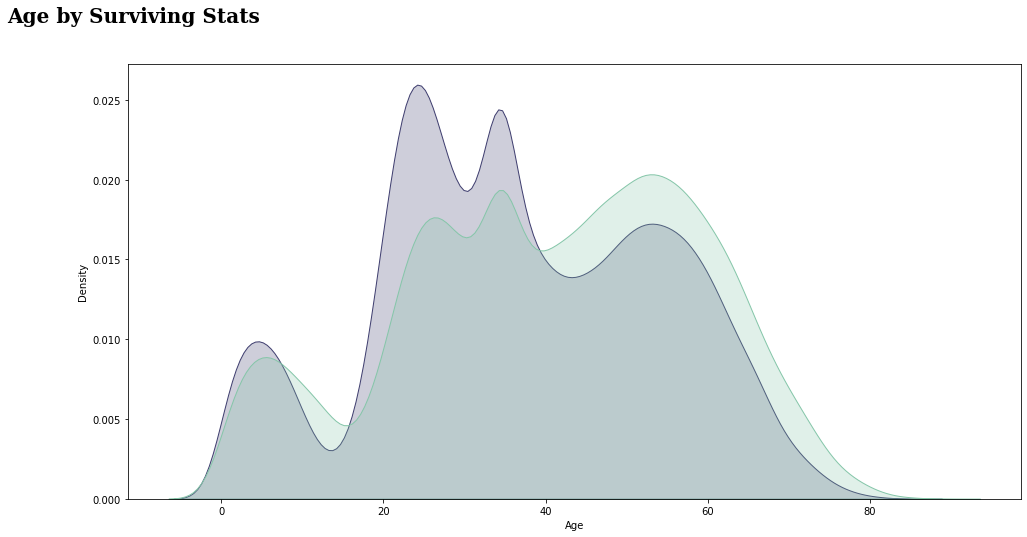

In [27]:
num_rows, num_cols = 2,1 #2행 1열로지정
#틀 지정
f, axes = plt.subplots(figsize=(16, 8))
f.suptitle('Age by Surviving Stats', fontsize=20, fontweight='bold', fontfamily='serif', x=0.13)


sns.kdeplot(all_df.loc[all_df['Survived']==0,'Age'],color=color_nsurv,shade=True)
sns.kdeplot(all_df.loc[all_df['Survived']==1,'Age'],color=color_surv,shade=True)

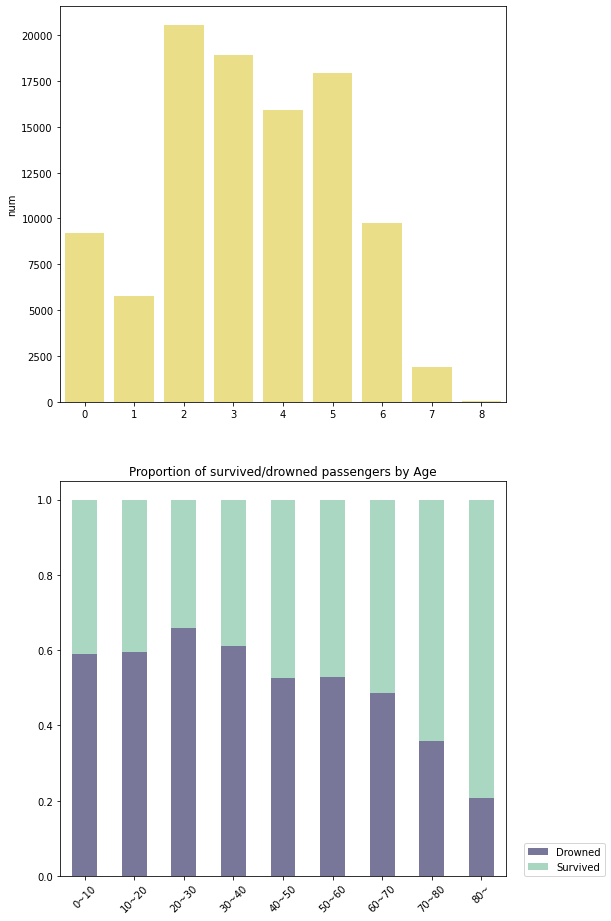

In [28]:
list_order=["0~10","10~20","20~30","30~40","40~50","50~60","60~70","70~80","80~"]
pd_age=category_feature_survived('Age',10,8)
draw_plot_num('Age',pd_age,list_order)

### Cabin

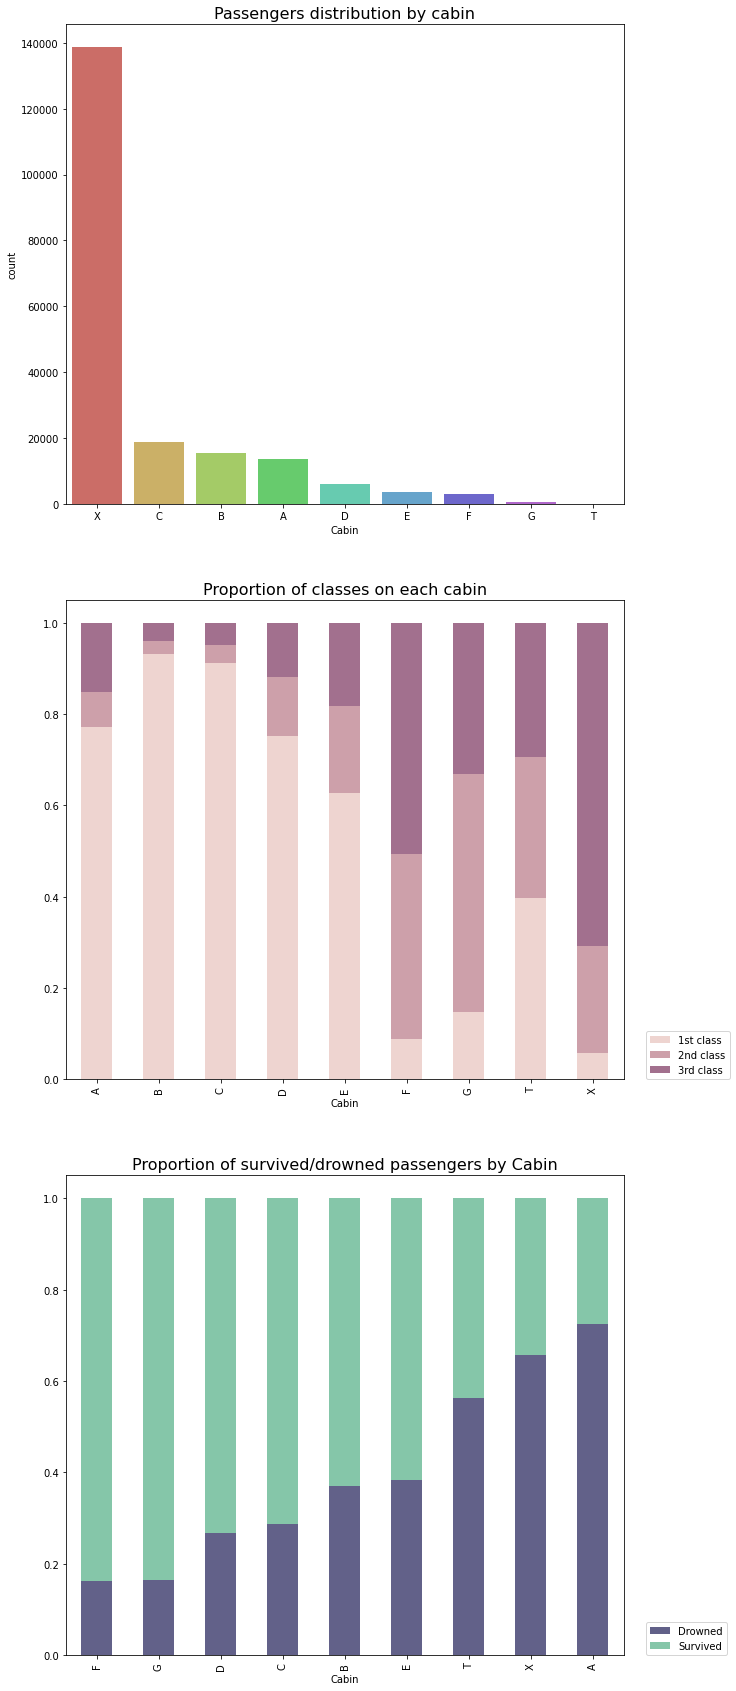

In [29]:
fig, ax= plt.subplots(ncols=1,nrows=3,figsize=(10,30))

#첫번째 그래프
sns.countplot(ax=ax[0],x = 'Cabin', data = all_df, palette = "hls", order = all_df['Cabin'].value_counts().index)
ax[0].set_title('Passengers distribution by cabin',fontsize= 16)


#두번째 그래프
cabin_by_class = all_df.groupby('Cabin')['Pclass'].value_counts(normalize = True).unstack()

cabin_by_class.plot(kind='bar', stacked='True',color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax[1])
ax[1].legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
ax[1].set_title('Proportion of classes on each cabin',fontsize= 16)


#세번째 그래프
Cabin_by_survived = all_df.groupby('Cabin')['Survived'].value_counts(normalize = True).unstack()
Cabin_by_survived = Cabin_by_survived.sort_values(by = 1, ascending = False)
Cabin_by_survived.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax[2])
ax[2].set_title('Proportion of survived/drowned passengers by Cabin',fontsize= 16)
ax[2].legend(( 'Drowned', 'Survived'), loc=(1.04,0))
#ax[2].xticks(rotation = False)
#ax[2].tight_layout()

### Pclass

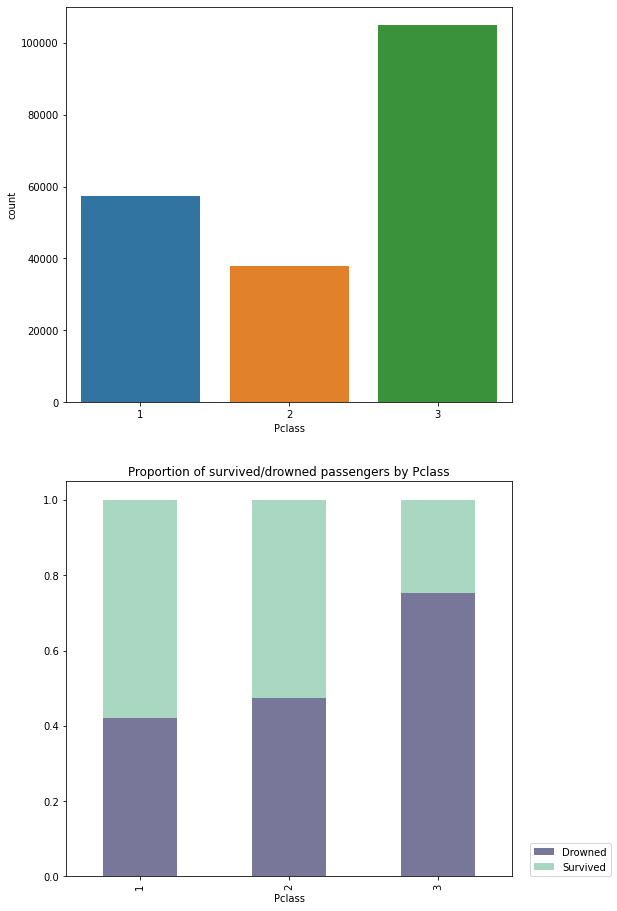

In [30]:
draw_plot('Pclass')

In [31]:
# fig = plt.figure(figsize=(14, 5))

# ax1 = fig.add_subplot(121)
# sns.countplot(x = 'Pclass', hue = 'Survived', data = all_df, palette=["#3f3e6fd1", "#85c6a9"], ax = ax1)
# plt.title('Number of survived/drowned passengers by class (train data)')
# plt.ylabel('Number of passengers')
# plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
# _ = plt.xticks(rotation=False)

# ax2 = fig.add_subplot(122)
# d = all_df.groupby('Pclass')['Survived'].value_counts(normalize = True).unstack()
# d.plot(kind='bar', stacked='True', ax = ax2, color =["#3f3e6fd1", "#85c6a9"])
# plt.title('Proportion of survived/drowned passengers by class (train data)')
# plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
# _ = plt.xticks(rotation=False)

# plt.tight_layout()

### pclass에 상관관계?

### EMBARKED



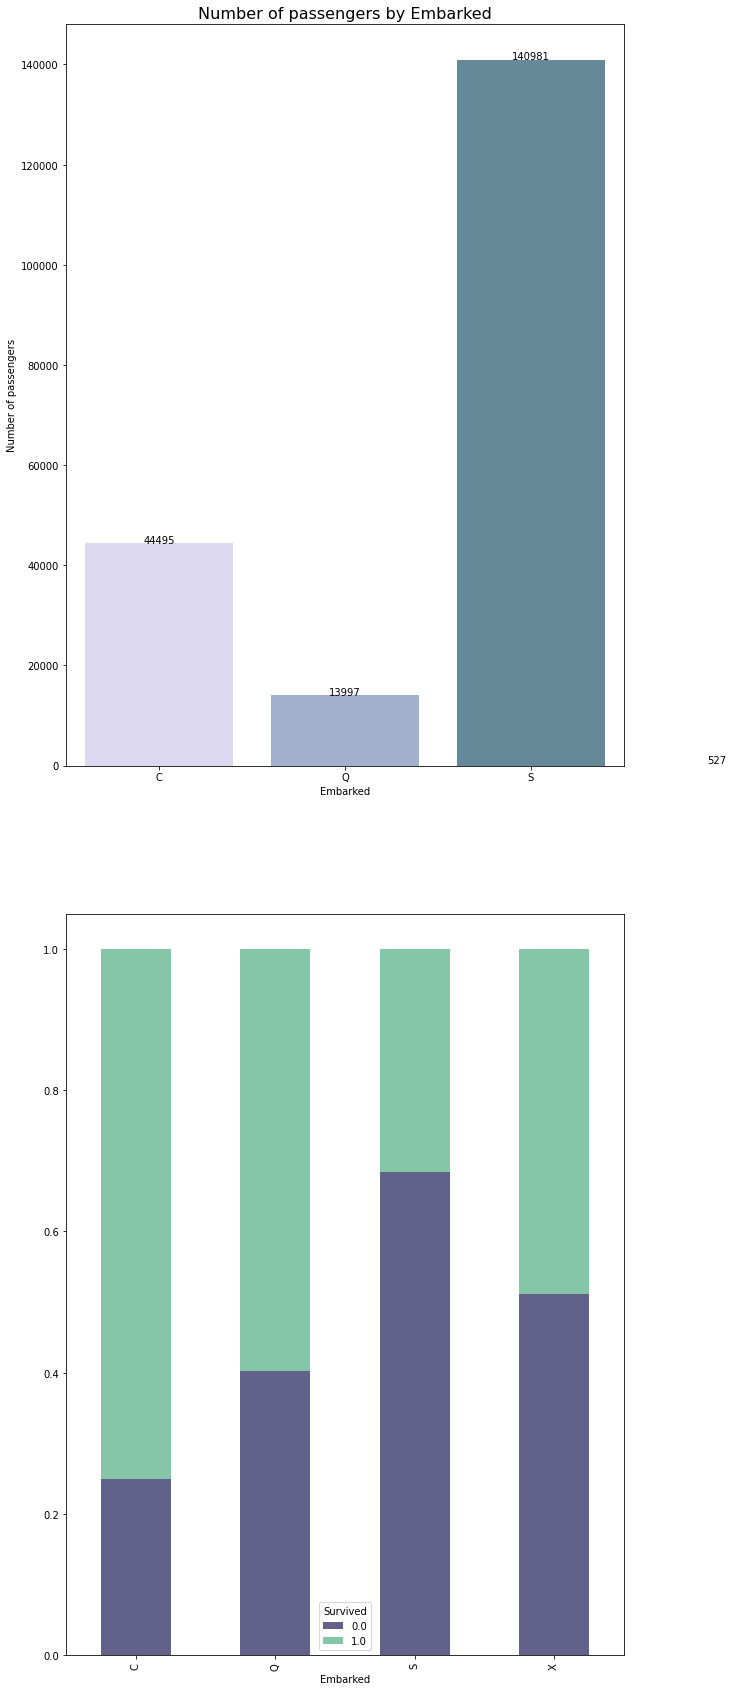

In [32]:
fig, ax2= plt.subplots(ncols=1,nrows=2,figsize=(10,30))

#첫번째 그래프
palette = sns.cubehelix_palette(5, start = 2)
sns.countplot(all_df['Embarked'], palette = palette, order = ['C', 'Q', 'S'],ax=ax2[0])
ax2[0].set_title('Number of passengers by Embarked',fontsize= 16)
ax2[0].set_ylabel('Number of passengers')

labels = (all_df['Embarked'].value_counts())
labels = labels.sort_index()
# add result numbers on barchart
for i, v in enumerate(labels):
    ax2[0].text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

#두번째 그래프

surv_by_emb = all_df.groupby('Embarked')['Survived'].value_counts(normalize = True)
surv_by_emb = surv_by_emb.unstack().sort_index()
surv_by_emb.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"],ax=ax2[1])
ax[1].set_title('Proportion of survived/drowned passengers by Embarked (train data)')
ax[1].legend(( 'Drowned', 'Survived'), loc=(1.04,0))



### Name

In [33]:
Name_temp=pd.DataFrame()
Name_temp=all_df.groupby('Name')['Name'].count().sort_values(ascending=False)

Text(0.5, 1.0, 'Passengers distribution by cabin')

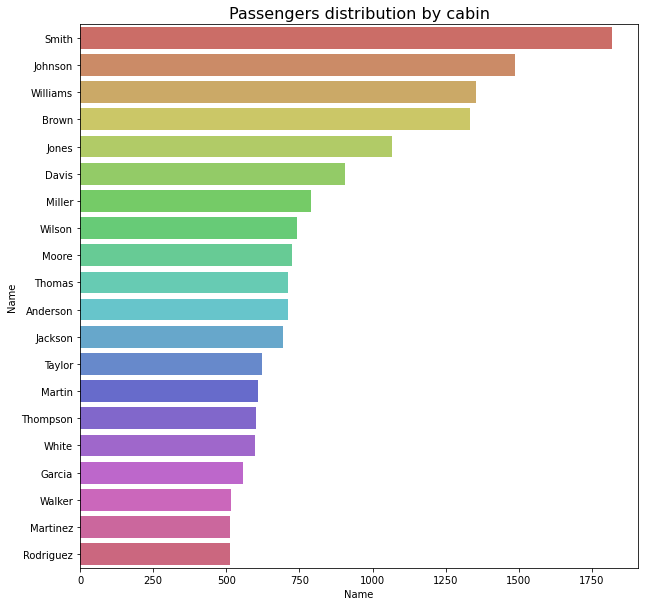

In [34]:
fig, ax= plt.subplots(ncols=1,nrows=1,figsize=(10,10))

#첫번째 그래프
ax= sns.barplot(x=Name_temp[1:].iloc[:20], y = Name_temp.iloc[:20].index, palette = "hls")
ax.set_title('Passengers distribution by cabin',fontsize= 16)

#### 이름에 따른 생존률


Text(0.5, 1.0, 'Survived distribution by Name')

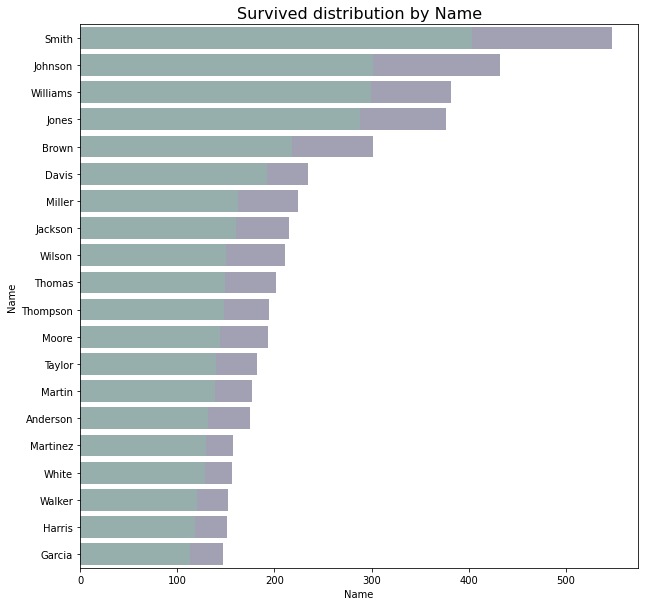

In [35]:
data_0=all_df.loc[all_df['Survived']==0].groupby('Name')['Name'].count().sort_values(ascending=False)
data_1=all_df.loc[all_df['Survived']==1].groupby('Name')['Name'].count().sort_values(ascending=False)
# data_0 = data_0 if len(data_0) < 10 else data_0[:10]
# data_1 = data_1 if len(data_1) < 10 else data_1[:10]


fig,ax= plt.subplots(figsize=(10,10))
ax= sns.barplot(x=data_0[1:].iloc[:20], y = data_0.iloc[:20].index, color=color_nsurv,alpha=0.5)
ax= sns.barplot(x=data_1[1:].iloc[:20], y = data_1.iloc[:20].index, color=color_surv,alpha=0.5)
ax.set_title('Survived distribution by Name',fontsize= 16)


### Sex

In [36]:
class_by_sex = all_df.groupby('Sex')['Pclass'].value_counts(normalize = True)['female']
class_by_sex

Pclass
3    0.395405
1    0.359657
2    0.244938
Name: Pclass, dtype: float64

Sex
female    12660
male      44566
Name: Sex, dtype: int64


Text(0.5, 1.0, 'Proportion of clases by Embarked')

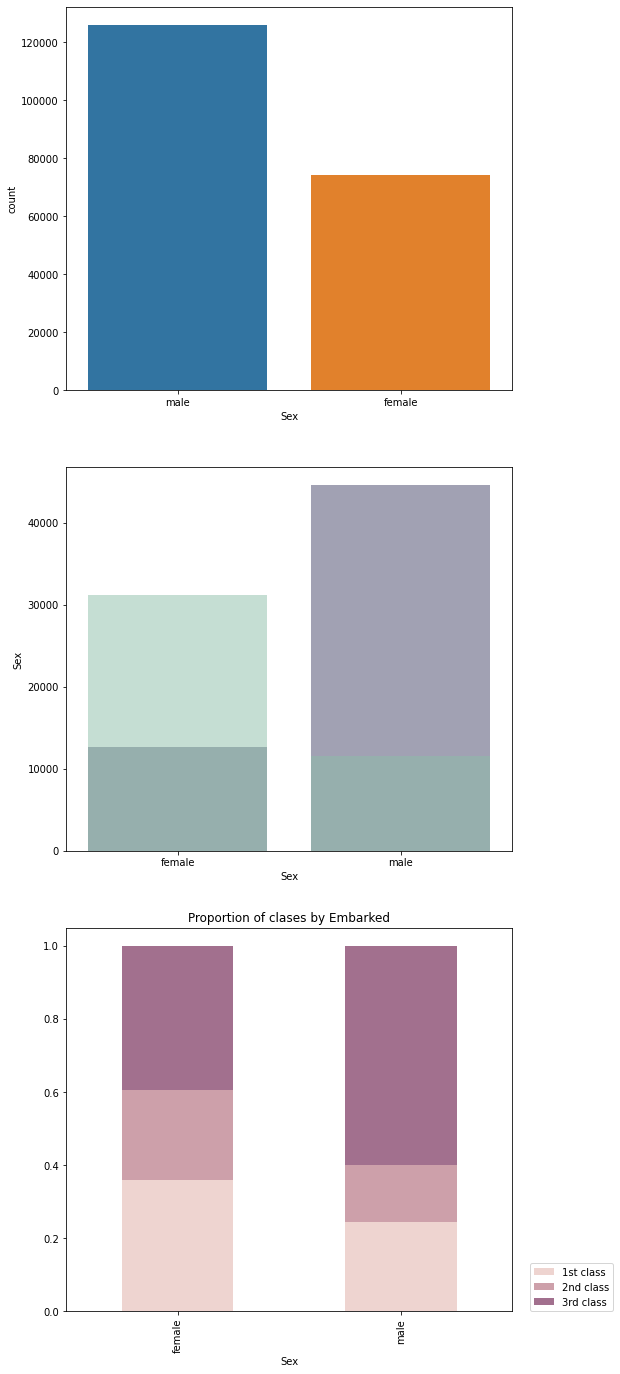

In [37]:
fig, ax10= plt.subplots(nrows=3,ncols=1,figsize=(8,24))
# ax10[0]=sns.countplot(all_df['Sex'],order=['male','female'])
sns.countplot(all_df['Sex'],order=['male','female'], ax=ax10[0])


#
data_sex_0=all_df.loc[all_df['Survived']==0].groupby('Sex')['Sex'].count()
data_sex_1=all_df.loc[all_df['Survived']==1].groupby('Sex')['Sex'].count()
print(data_sex_0)
#seaborn 패키지에서는 ax객체를 파라미터에서 지정해줘야함.
sns.barplot(x=data_sex_0.index,y=data_sex_0, order=data_sex_0.index,color=color_nsurv,alpha=0.5,ax=ax10[1])
sns.barplot(x=data_sex_1.index,y=data_sex_1, order=data_sex_1.index,color=color_surv,alpha=0.5,ax=ax10[1])

class_by_sex = all_df.groupby('Sex')['Pclass'].value_counts(normalize = True)
class_by_sex = class_by_sex.unstack().sort_index()
class_by_sex.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax10[2])

ax10[2].legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
ax10[2].set_title('Proportion of clases by Embarked')

### Sibsp

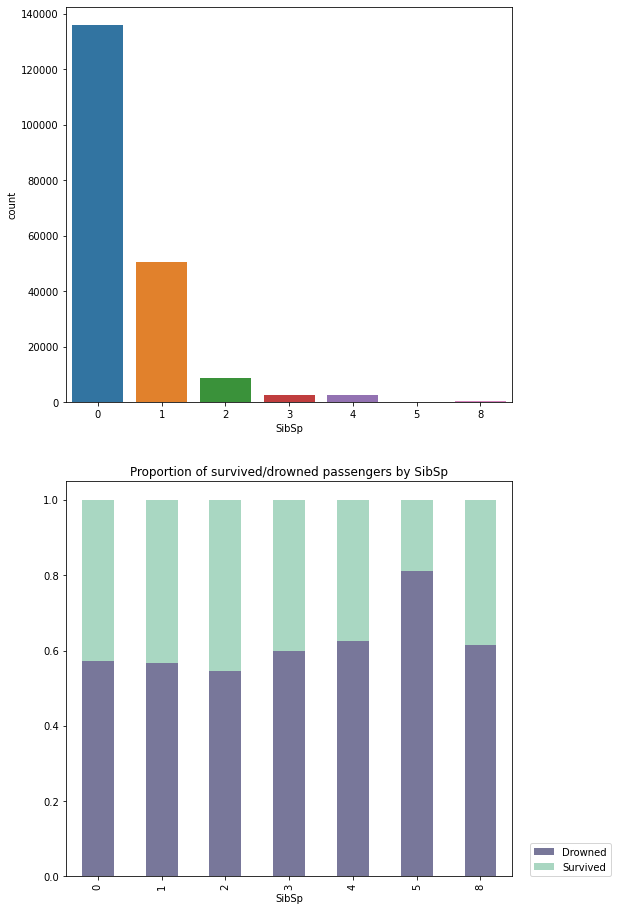

In [38]:
draw_plot('SibSp')

### Parch

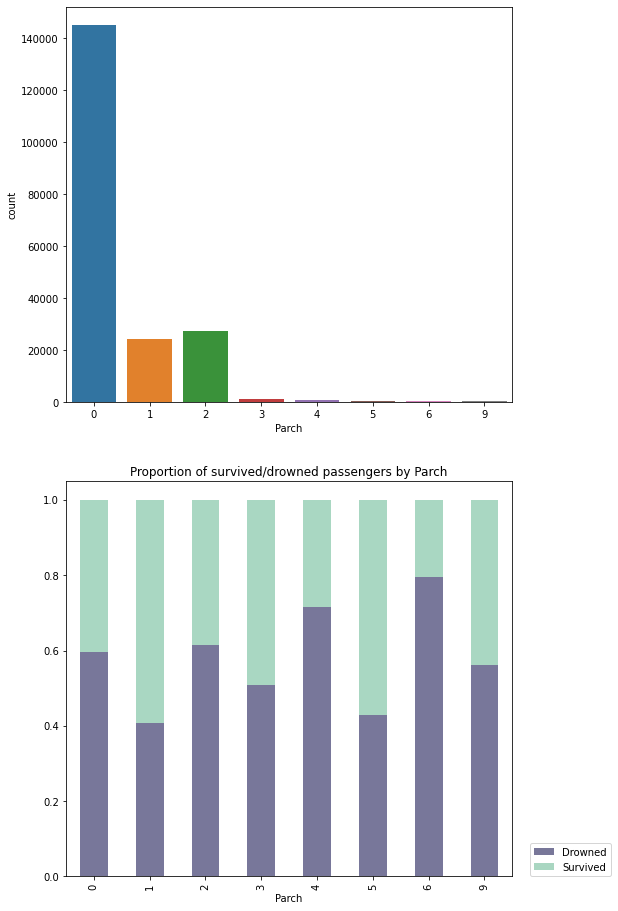

In [39]:
draw_plot('Parch')

### Ticket

Text(0.5, 1.0, 'Survived distribution by Ticket')

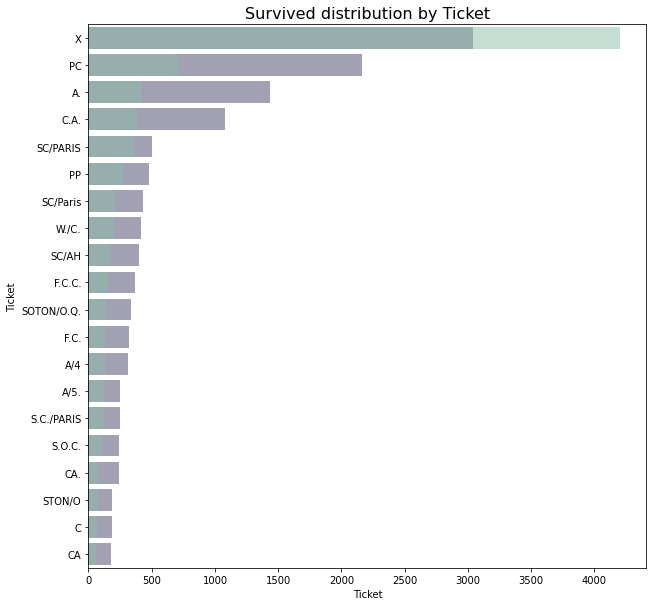

In [40]:
data_0=all_df.loc[all_df['Survived']==0].groupby('Ticket')['Ticket'].count().sort_values(ascending=False)
data_1=all_df.loc[all_df['Survived']==1].groupby('Ticket')['Ticket'].count().sort_values(ascending=False)
# data_0 = data_0 if len(data_0) < 10 else data_0[:10]
# data_1 = data_1 if len(data_1) < 10 else data_1[:10]


fig,ax= plt.subplots(figsize=(10,10))
ax= sns.barplot(x=data_0[1:].iloc[:20], y = data_0.iloc[:20].index, color=color_nsurv,alpha=0.5)
ax= sns.barplot(x=data_1[1:].iloc[:20], y = data_1.iloc[:20].index, color=color_surv,alpha=0.5)
ax.set_title('Survived distribution by Ticket',fontsize= 16)

### Fare

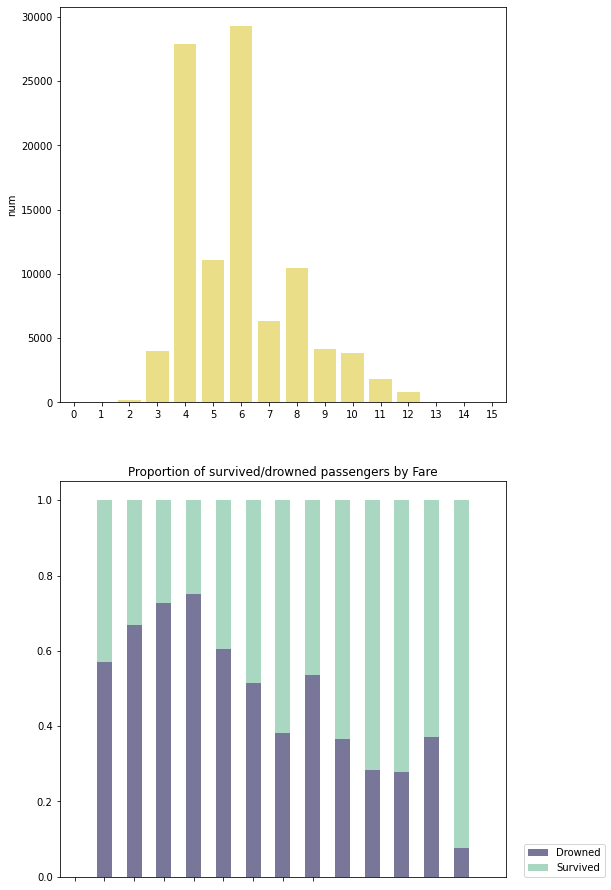

In [41]:
list_order=[]
pd_fare=category_feature_survived('Fare',0.5,15)
draw_plot_num('Fare',pd_fare,list_order)

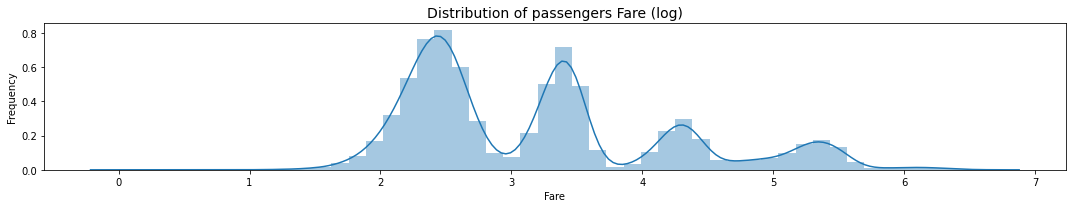

In [42]:
plt.figure(figsize=(15,3))

sns.distplot(all_df[(all_df['Fare']>0)].Fare)

plt.title('Distribution of passengers Fare (log)', fontsize=14)
plt.xlabel('Fare')
plt.ylabel('Frequency')

plt.tight_layout()



### 각 피쳐들의 상관 관계


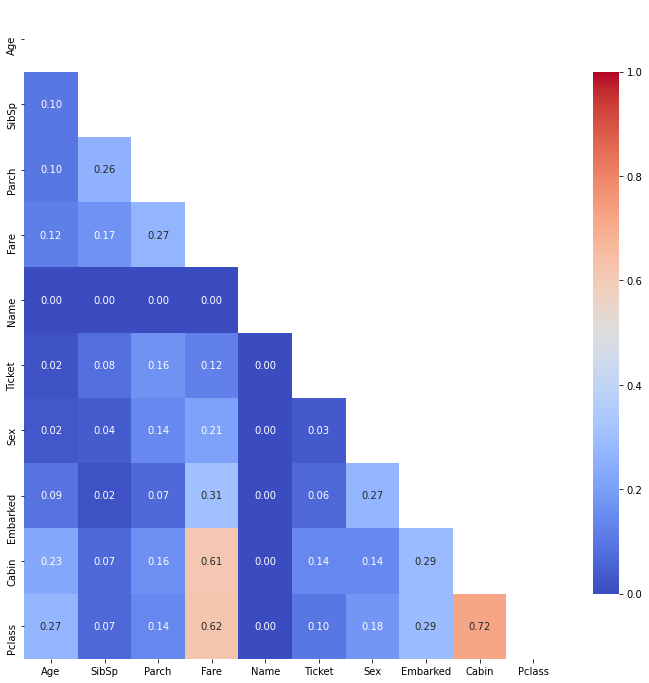

In [43]:
feature_cols = cor_df.drop(['Survived'], axis=1).columns
corr_total = cor_df[feature_cols].corr().abs()

mask=np.triu(np.ones_like(corr_total,dtype=np.bool))
#triu : 밑쪽 삼각형이 0인 배열을 만들어낸다. 
# ones_like(corr,dtype=np.bool) : corr을 Bool타입으로 생성한다. 

fig, ax_cor_t = plt.subplots(figsize=(12, 12))
#ax.text(-1.1, 0.16, 'Correlation between the Continuous Features', fontsize=20, fontweight='bold', fontfamily='serif')
#ax.text(-1.1, 0.3, 'There is no features that pass 0.4 correlation within each other', fontsize=13, fontweight='light', fontfamily='serif')


#heatmap 함수로 상관관계를 색의 진함으로 판단. mask가 없으면 대칭으로 나온다. 
sns.heatmap(corr_total,mask=mask,annot=True,
            fmt=".2f",
            cbar_kws={"shrink": .8},
            vmin=0, vmax=1,
            cmap='coolwarm')
#annot=True: 숫자 표시, cbar_kws={"shrink": .8}는 옆에 바 띄워줌?
#vmin=0, vmax=1 는 0~1사이의 농도로 맞춰줌

plt.show()

### Fare 과 Cabin, Pclass

#### FARE과 Pclass

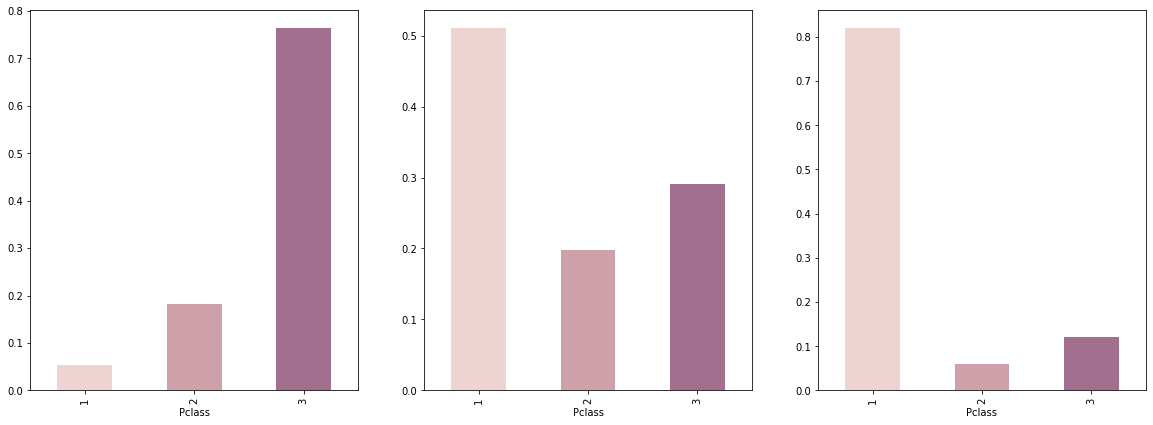

In [44]:
fig, ax= plt.subplots(ncols=3,nrows=1,figsize=(20,7))
temp_list_cat=[all_df.groupby((all_df.Fare>0)&(all_df.Fare<=3))['Pclass'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Fare>3)&(all_df.Fare<=6))['Pclass'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Fare>6))['Pclass'].value_counts(normalize = True)[True]]


for i in range(len(temp_list_cat)):
    
    temp_list_for= temp_list_cat[i].sort_index()
    temp_list_for.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax[i])



### Fare과 cabin

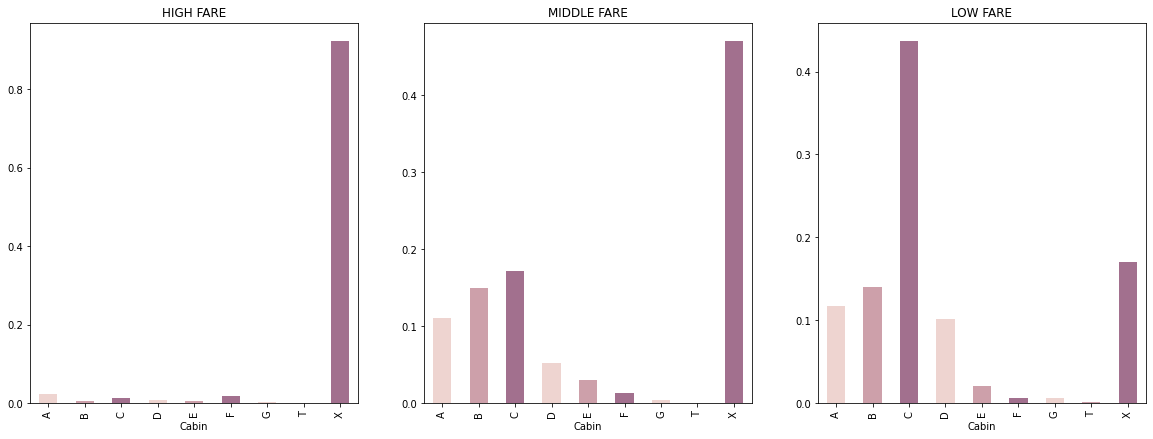

In [45]:
fig, ax= plt.subplots(ncols=3,nrows=1,figsize=(20,7))
temp_list_cat=[all_df.groupby((all_df.Fare>0)&(all_df.Fare<=3))['Cabin'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Fare>3)&(all_df.Fare<=6))['Cabin'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Fare>6))['Cabin'].value_counts(normalize = True)[True]]

list_title=['LOW FARE','MIDDLE FARE','HIGH FARE']
for i in range(len(temp_list_cat)):
    
    temp_list_for= temp_list_cat[i].sort_index()
    temp_list_for.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax[i])
    ax[i].set_title(list_title[2-i])

#### pclass에 대한 각각의 상관관계 

#### -cabin

Text(0.5, 1.0, 'Proportion of clases by Embarked')

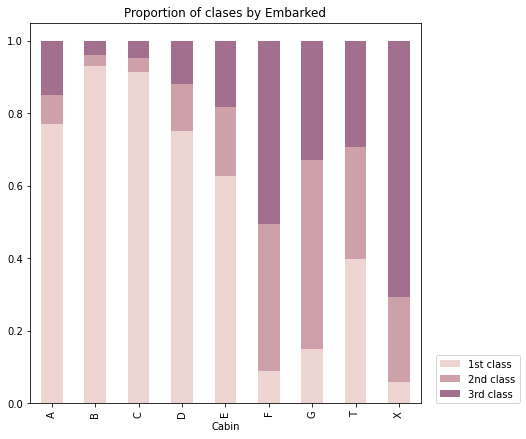

In [46]:
fig, ax= plt.subplots(ncols=1,nrows=1,figsize=(7,7))
class_by_emb = all_df.groupby('Cabin')['Pclass'].value_counts(normalize = True)
class_by_emb = class_by_emb.unstack().sort_index()
class_by_emb.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax)
ax.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
ax.set_title('Proportion of clases by Embarked')

#### -EMbarked

Text(0.5, 1.0, 'Proportion of clases by Embarked')

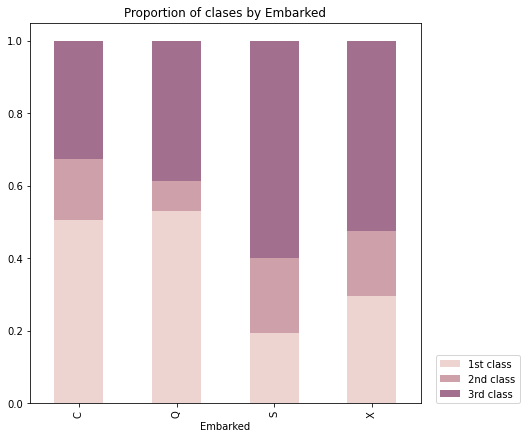

In [47]:
#세번째 그래프
fig, ax= plt.subplots(ncols=1,nrows=1,figsize=(7,7))
class_by_emb = all_df.groupby('Embarked')['Pclass'].value_counts(normalize = True)
class_by_emb = class_by_emb.unstack().sort_index()
class_by_emb.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax)
ax.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
ax.set_title('Proportion of clases by Embarked')

> pclass는 fare뿐만 아니라 Embarked, cabin과도 연관성이 나타난다. 

### Parch 와 Sibsp 
Parch는 가족의 수.
Sibsp는 형제자매의 수이다.
그래서 이 두 독립변수간의 유의미한 상관관계가 있는지 살펴 본다. 

Text(0.5, 1.0, 'Proportion of clases by parch and sibsp')

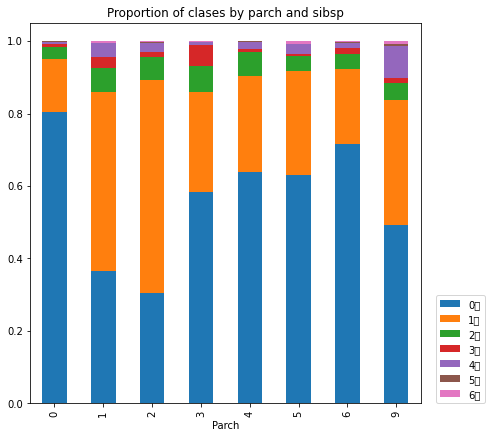

In [48]:
fig, ax= plt.subplots(ncols=1,nrows=1,figsize=(7,7))
class_by_emb = all_df.groupby('Parch')['SibSp'].value_counts(normalize = True)
class_by_emb = class_by_emb.unstack().sort_index()
class_by_emb.plot(kind='bar', stacked='True', ax = ax)
ax.legend(('0명', '1명','2명','3명','4명','5명','6명','7명','8명'), loc=(1.04,0))
ax.set_title('Proportion of clases by parch and sibsp')

#### 가족수 별 나이

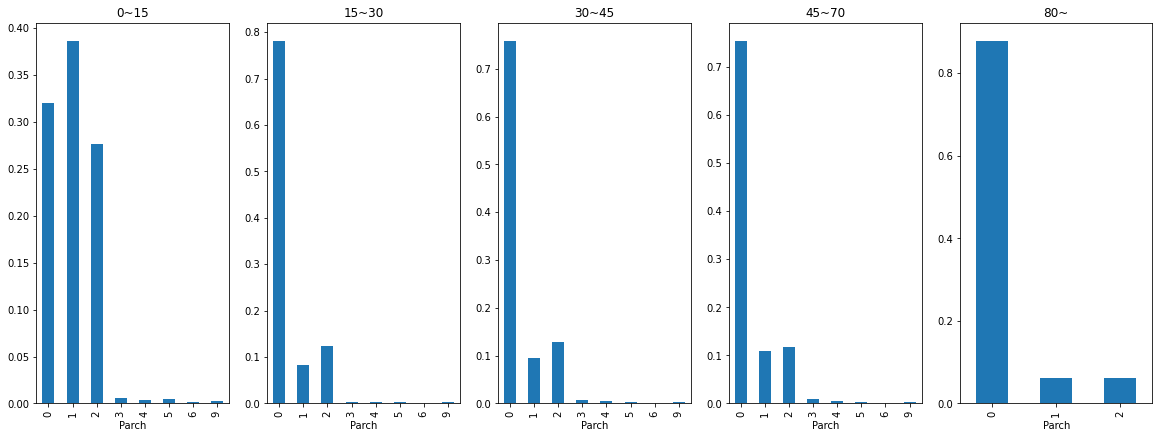

In [49]:
fig, ax= plt.subplots(ncols=5,nrows=1,figsize=(20,7))
temp_list_cat=[all_df.groupby((all_df.Age>0)&(all_df.Age<=15))['Parch'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>15)&(all_df.Age<=30))['Parch'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>30)&(all_df.Age<=45))['Parch'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>45)&(all_df.Age<=70))['Parch'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>80))['Parch'].value_counts(normalize = True)[True]]

list_index=['0~15','15~30','30~45','45~70','80~']
for i in range(len(temp_list_cat)):
    
    temp_list_for= temp_list_cat[i].sort_index()
    temp_list_for.plot(kind='bar', stacked='True', ax = ax[i])
    ax[i].set_title(list_index[i])

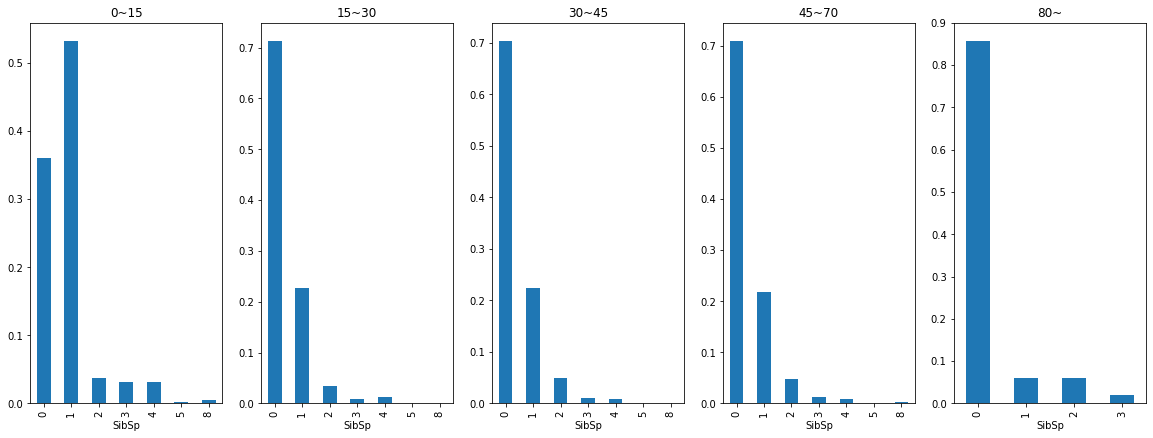

In [50]:
fig, ax= plt.subplots(ncols=5,nrows=1,figsize=(20,7))
temp_list_cat=[all_df.groupby((all_df.Age>0)&(all_df.Age<=15))['SibSp'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>15)&(all_df.Age<=30))['SibSp'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>30)&(all_df.Age<=45))['SibSp'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>45)&(all_df.Age<=70))['SibSp'].value_counts(normalize = True)[True],
               all_df.groupby((all_df.Age>80))['SibSp'].value_counts(normalize = True)[True]]

list_index=['0~15','15~30','30~45','45~70','80~']
for i in range(len(temp_list_cat)):
    
    temp_list_for= temp_list_cat[i].sort_index()
    temp_list_for.plot(kind='bar', stacked='True', ax = ax[i])
    ax[i].set_title(list_index[i])

In [51]:
all_df['Pclass'].value_counts().sort_index().index

Int64Index([1, 2, 3], dtype='int64')

In [52]:
def cat_for_num(num_feature,cat_feature,index_tuple):
    list_temp=all_df[cat_feature].value_counts().sort_index().index
    temp_class=[]
    plt.figure(figsize=(20,6))
    for i in range(len(list_temp)):
        age_1_class = all_df[(all_df[num_feature]>0)&(all_df[cat_feature]==list_temp[i])]
        sns.kdeplot(age_1_class[num_feature], shade=True,label = '1st class',alpha=0.6)

        
        

    # Ploting the 3 variables that we create


    plt.title('Age distribution grouped by {}(total data)'.format(cat_feature),fontsize= 16)
    plt.legend(index_tuple, loc=(1.04,0))
    plt.xlabel(num_feature)
    plt.xlim(0, 90)
    plt.tight_layout()
    plt.show()
    

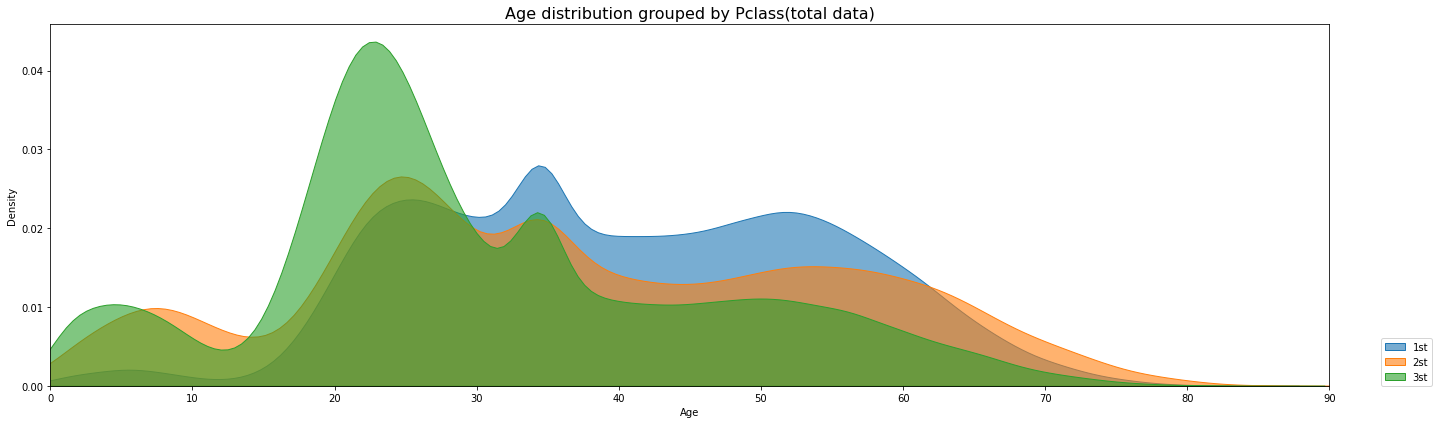

In [53]:
index_tuple=('1st','2st','3st')
cat_for_num('Age','Pclass',index_tuple)

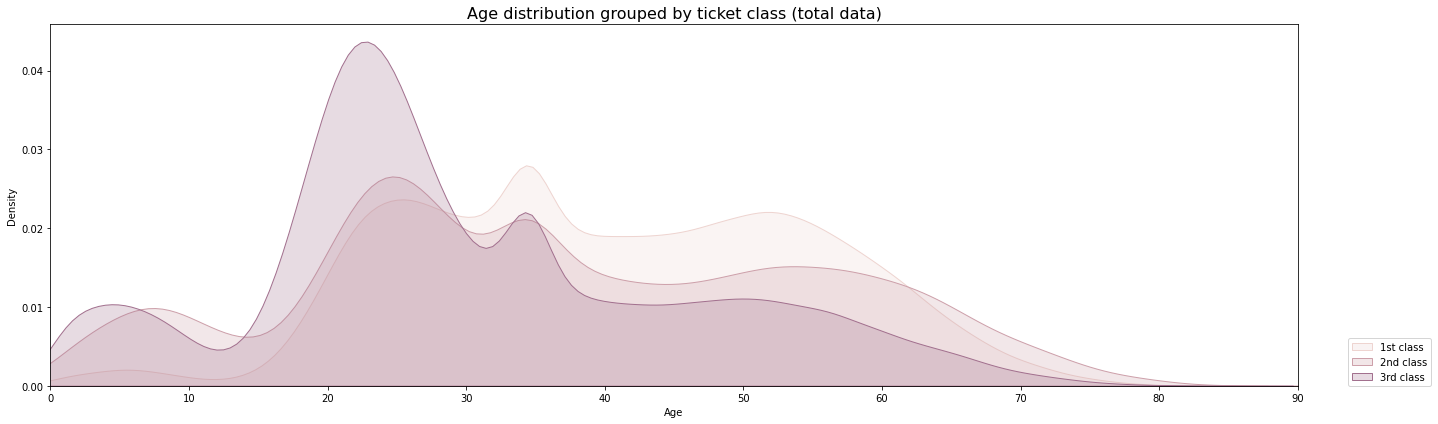

In [54]:
plt.figure(figsize=(20,6))
plt.subplot()
age_1_class = all_df[(all_df['Age']>0)&(all_df['Pclass']==1)]
age_2_class = all_df[(all_df['Age']>0)&(all_df['Pclass']==2)]
age_3_class = all_df[(all_df['Age']>0)&(all_df['Pclass']==3)]

# Ploting the 3 variables that we create
sns.kdeplot(age_1_class["Age"], shade=True, color='#eed4d0', label = '1st class')
sns.kdeplot(age_2_class["Age"], shade=True,  color='#cda0aa', label = '2nd class')
sns.kdeplot(age_3_class["Age"], shade=True,color='#a2708e', label = '3rd class')
plt.title('Age distribution grouped by ticket class (total data)',fontsize= 16)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
plt.xlabel('Age')
plt.xlim(0, 90)
plt.tight_layout()
plt.show()

## 모델링

In [55]:
train = all_df.iloc[:100000, :]#0개~100000개
test = all_df.iloc[100000:, :] #100000개~ 
#iloc은 정수형 인덱싱
test = test.drop('Survived', axis=1) #test에서 종속변수를 드랍한다. 
model_results = pd.DataFrame()
folds = 5

In [56]:
y= train.loc[:,'Survived']
X= train.drop('Survived',axis=1)

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)


In [58]:
from sklearn import metrics  
from sklearn.metrics import accuracy_score
import numpy as np

In [59]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [60]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
53349,53349,1,Delung,male,5.0,1,2,C.A.,4.159820,A,S
30857,30857,1,Collins,female,36.0,1,2,X,4.317355,C,S
41671,41671,3,Cassidy,male,29.0,0,0,X,2.240710,X,S
44288,44288,1,Jolivette,male,2.0,0,0,X,3.388787,C,S
81,81,3,Novack,male,60.0,0,0,X,2.600465,X,S


In [61]:
lgbm_model=lgb.LGBMClassifier(**params)
lgbm_model.fit(X_train,y_train)
lgbm_pred=lgbm_model.predict(X_valid)
lgbm_R2=metrics.accuracy_score(y_valid,lgbm_pred)
#lgbm_rmse = np.sqrt(mean_squared_error(lgbm_pred,y_valid))
print('R2 : ',lgbm_R2)
#print("RMSE : ", lgbm_rmse)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: Name, Sex, Ticket, Cabin, Embarked

In [62]:
print(train.isna().sum())
print(train['Survived'].isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
0


In [63]:
train_kf_feature=train.drop('Survived',axis=1)
train_kf_label=train.loc[:,'Survived']

In [64]:
n_iter=0
kfold=StratifiedKFold(n_splits=5)
cv_accuracy=[]
feature_importances = pd.DataFrame()

for train_idx, test_idx in kfold.split(train_kf_feature,train_kf_label):

    X_train=train_kf_feature.iloc[train_idx]
    X_test=train_kf_feature.iloc[test_idx]
    y_train,y_test=train_kf_label.iloc[train_idx],train_kf_label.iloc[test_idx]
    #학습 진행
    lgbm_model.fit(X_train,y_train)
    #예측
    fold_pred=lgbm_model.predict(X_test)
    
    #정확도
    n_iter+=1
    fold_accuracy=metrics.accuracy_score(y_test,fold_pred)
    print("\n {}번째  교차 검증 정확도 : {} , 학습 데이터 크기:{}, 검증 데이터 크기 :{} ".
          format(n_iter,fold_accuracy,X_train.shape[0],X_test.shape[0]))
    cv_accuracy.append(fold_accuracy)
    
    #중요도 
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = lgbm_model.feature_name_
    fi_tmp["importance"] = lgbm_model.feature_importances_
    feature_importances = feature_importances.append(fi_tmp)

print('\n 평균 검증 정확도 : ',np.mean(cv_accuracy))
    

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: Name, Sex, Ticket, Cabin, Embarked

In [65]:
order = list(feature_importances.groupby("feature").
             mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("LGBMRegressor"))
plt.tight_layout()

KeyError: 'feature'

### CATBoost


In [66]:
# params_cat = {
#     'bootstrap_type': 'Poisson',
#     'loss_function': 'Logloss',
#     'eval_metric': 'Logloss',
#     'random_seed': SEED,
#     'task_type': 'GPU',
#     'max_depth': 8,
#     'learning_rate': 0.01,
#     'n_estimators': N_ESTIMATORS,
#     'max_bin': 280,
#     'min_data_in_leaf': 64,
#     'l2_leaf_reg': 0.01,
#     'subsample': 0.8
# }

In [67]:
#새로운 트레인 valid 셋
# X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)


In [68]:

# cat_model=ctb.CatBoostClassifier(**params_cat)
# cat_model.fit(X_train, y_train,verbose=300)
# cat_pred=cat_model.predict(X_valid)
# print("\n정확도: ", metrics.accuracy_score(y_valid, cat_pred))
# cat_R2=metrics.accuracy_score(y_valid,cat_pred)
# #lgbm_rmse = np.sqrt(mean_squared_error(lgbm_pred,y_valid))
# print('R2 : ',cat_R2)

In [69]:
# cv_accuracy=[]
# feature_importances = pd.DataFrame()

# for train_idx, test_idx in kfold.split(train_kf_feature,train_kf_label):

#     X_train=train_kf_feature.iloc[train_idx]
#     X_test=train_kf_feature.iloc[test_idx]
#     y_train,y_test=train_kf_label.iloc[train_idx],train_kf_label.iloc[test_idx]
#     #학습 진행
#     cat_model.fit(X_train,y_train,verbose=500)
#     #예측
#     fold_pred=cat_model.predict(X_test)
    
#     #정확도
#     n_iter+=1
#     fold_accuracy=metrics.accuracy_score(y_test,fold_pred)
#     print("\n {}번째  교차 검증 정확도 : {} , 학습 데이터 크기:{}, 검증 데이터 크기 :{} ".
#           format(n_iter,fold_accuracy,X_train.shape[0],X_test.shape[0]))
#     cv_accuracy.append(fold_accuracy)
    
#     #중요도 . lgbm이랑 명령어가 다르다.
#     fi_tmp = pd.DataFrame()
#     fi_tmp["feature"] = X_test.columns.to_list()
#     fi_tmp["importance"] = cat_model.get_feature_importance()
#     feature_importances = feature_importances.append(fi_tmp)

# print('\n 평균 검증 정확도 : ',np.mean(cv_accuracy))

In [70]:
# # just to get ideas to improve
# order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
# plt.figure(figsize=(10, 10))
# sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
# plt.title("{} importance".format("CatBoostClassifier"))
# plt.tight_layout()

## Submission


In [71]:
# def create_submission(model, X_test, test_passenger_id, model_name):
#     y_pred_test = model.predict_proba(test)[:, 1]
#     submission = pd.DataFrame(
#         {
#             'PassengerId': test_passenger_id, 
#             'Survived': (y_pred_test >= 0.5).astype(int),
#         }
#     )
#     submission.to_csv(f"submission_{model_name}.csv", index=False)
    
#     return y_pred_test

In [72]:
# test_df.shape

In [73]:
# test_pred_lightgbm = create_submission(
#     lgbm_model, X_test, test_df["PassengerId"], "lightgbm"
# )
# test_pred_catboost = create_submission(
#     cat_model, X_test, test_df["PassengerId"], "catboost"
#)

In [74]:
# test_pred_merged = (

#     test_pred_lightgbm + 
#     test_pred_catboost 
# )
# test_pred_merged = np.round(test_pred_merged / 2)

In [75]:
# submission = pd.DataFrame(
#     {
#         'PassengerId': test_df["PassengerId"], 
#         'Survived': test_pred_merged.astype(int),
#     }
# )
# submission.to_csv(f"submission_merged2.csv", index=False)